In [1]:
import pandas as pd

In [ ]:
!unzip ml-latest-small.zip

In [3]:
BASE_PATH = 'ml-latest-small'

links = pd.read_csv(f'{BASE_PATH}/links.csv', encoding='utf-8')
movies = pd.read_csv(f'{BASE_PATH}/movies.csv', encoding='utf-8')
ratings = pd.read_csv(f'{BASE_PATH}/ratings.csv', encoding='utf-8')
tags = pd.read_csv(f'{BASE_PATH}/tags.csv', encoding='utf-8')


In [4]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


# Data exploration

### 1. Children movies

In [6]:
is_children_movie = movies['genres'].str.contains('Children')
children_movies = movies.loc[is_children_movie]   #str.split('|')
print(is_children_movie.sum())

664


### 2. 95' Movies ratings dist.

In [7]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [8]:
movies["year"] = movies["title"].str.extract(r"\((\d{4})\)$")[0].fillna(0).astype("int")
# movies.info()
movies_95 = movies.loc[movies["year"] == 1995]
print(movies_95.shape)
movies_95.head()

(258, 4)


,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


<Axes: >

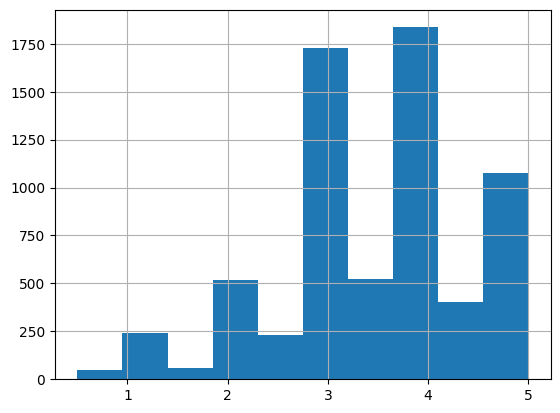

In [9]:
movies_ratings_95 = ratings.join(
    movies_95,
    on="movieId",
    lsuffix="_ratings",
    how="inner",
    validate="m:1",
)
movies_ratings_95["rating"].hist()

### 3.1. Average action movies' ratings

In [10]:
action_movies = movies.loc[movies.title.str.lower().str.contains("action")]
action_movies["title"].reset_index(drop=True)

0                       Last Action Hero (1993)
1                         Chain Reaction (1996)
2                        Civil Action, A (1998)
3                       Fatal Attraction (1987)
4                         Action Jackson (1988)
5                      Missing in Action (1984)
6     Missing in Action 2: The Beginning (1985)
7        Braddock: Missing in Action III (1988)
8               Rules of Attraction, The (2002)
9           Looney Tunes: Back in Action (2003)
10                    Laws of Attraction (2004)
11                          Class Action (1991)
Name: title, dtype: object

### 3.2. Top 3 action movies

In [11]:
ratings.join(
    action_movies,
    on="movieId",
    lsuffix="_ratings",
    how="inner",
    validate="m:1",
).groupby("title")["rating"].mean().sort_values(ascending=False).head(3)

title
Braddock: Missing in Action III (1988)       4.000000
Missing in Action 2: The Beginning (1985)    3.750000
Chain Reaction (1996)                        3.537037
Name: rating, dtype: float64

### 3.3. Top 3 movies

In [12]:
ratings.join(
    movies,
    on="movieId",
    lsuffix="_ratings",
    how="inner",
    validate="m:1",
).groupby("title")['rating'].mean().sort_values(ascending=False).head(3)

title
Fallen Angels (Duo luo tian shi) (1995)    5.0
San Francisco (1936)                       5.0
Valentine (2001)                           5.0
Name: rating, dtype: float64

# Recommendation system

In [ ]:
%pip install scikit-surprise

### 1. SVD & KNN

In [14]:
from surprise import Dataset, Reader


reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[["userId", "movieId", "rating"]], reader)

In [15]:
from surprise import SVD, KNNBasic


algo_svd = SVD(n_factors=40, n_epochs=20, reg_bu=15)
algo_knn = KNNBasic(k=40, sim_options={"name": "cosine", "user_based": False})

In [16]:
trainset = data.build_full_trainset()

algo_svd.fit(trainset)
algo_knn.fit(trainset)

TOY_STORY_ID = 1
USER_ID = 7

prediction_svd = algo_svd.predict(uid=USER_ID, iid=TOY_STORY_ID, r_ui=4.5)
prediction_knn = algo_knn.predict(uid=USER_ID, iid=TOY_STORY_ID, r_ui=4.5)
print(f"Predicted SVD rating: {prediction_svd.est:.2f}", end="\n\t")
print(prediction_svd)
print(f"Predicted KNN rating: {prediction_knn.est:.2f}", end="\n\t")
print(prediction_knn)


Computing the cosine similarity matrix...
Done computing similarity matrix.
Predicted SVD rating: 3.93
	user: 7          item: 1          r_ui = 4.50   est = 3.93   {'was_impossible': False}
Predicted KNN rating: 3.89
	user: 7          item: 1          r_ui = 4.50   est = 3.89   {'actual_k': 40, 'was_impossible': False}


### 2. After-Toy-Story recommendations

In [17]:
new_user = ratings.userId.max() + 1
new_ratings = pd.concat(
    [
        ratings,
        pd.DataFrame(
            {
                "userid": new_user,
                "movieId": 1,
                "rating": 4.5,
                "timestamp": 1493846358,
            },
            index=[ratings.shape[0]],
        ),
    ],
)
new_reader = Reader(rating_scale=(0.5, 5.0))
new_data = Dataset.load_from_df(new_ratings[["userId", "movieId", "rating"]], new_reader)
trainset = new_data.build_full_trainset()
algo_svd = SVD(n_factors=40, n_epochs=20, reg_bu=15)
algo_knn = KNNBasic(k=40, sim_options={"name": "cosine", "user_based": False})
algo_svd.fit(trainset)
algo_knn.fit(trainset)


Computing the cosine similarity matrix...
Done computing similarity matrix.


In [18]:
TOP_N = 3
unwatched_movies = set(ratings["movieId"]) - {TOY_STORY_ID}
len(unwatched_movies)

9723

#### 2.1. SVD recommendations

In [19]:
predictions_svd = sorted(
    (algo_svd.predict(uid=new_user, iid=movie_id) for movie_id in unwatched_movies),
    key=lambda x: x.est,
    reverse=True,
)
print(f"Top {TOP_N} SVD recommendations for user {new_user}:")
for prediction in predictions_svd[:TOP_N]:
    print(f"\t{movies.loc[movies.movieId == prediction[1]]['title'].values[0]}: {prediction[3]:.2f}(est), {prediction[2]}(real)")


Top 3 SVD recommendations for user 611:
	Shawshank Redemption, The (1994): 4.41(est), None(real)
	Streetcar Named Desire, A (1951): 4.33(est), None(real)
	Godfather, The (1972): 4.27(est), None(real)


#### 2.2. KNN recommendations

In [20]:
predictions_knn = sorted(
    (algo_knn.predict(uid=new_user, iid=movie_id) for movie_id in unwatched_movies),
    key=lambda x: x.est,
    reverse=False,
)
print(f"Top {TOP_N} KNN recommendations for user {new_user}:")
for prediction in predictions_knn[:TOP_N]:
    print(
        f"\t{movies.loc[movies.movieId == prediction[1]]['title'].values[0]}: {prediction[3]:.2f}(est), {prediction[2]}(real)"
    )

Top 3 KNN recommendations for user 611:
	Jumanji (1995): 3.50(est), None(real)
	Grumpier Old Men (1995): 3.50(est), None(real)
	Waiting to Exhale (1995): 3.50(est), None(real)


### 3. Grid Optimization

#### 3.1. SVD

In [21]:
from surprise.model_selection import GridSearchCV


param_grid = {
    "n_epochs": [5, 10],
    "lr_all": [0.002, 0.005],
    "reg_all": [0.4, 0.6],
}
gs_svd = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], cv=3)
gs_svd.fit(data)

In [22]:
# best RMSE score
print(gs_svd.best_score["rmse"])

# combination of parameters that gave the best RMSE score
print(gs_svd.best_params["rmse"])

0.893899634929717
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


In [23]:
algo_svd_tuned = gs_svd.best_estimator["rmse"]
algo_svd_tuned.fit(trainset)

#### 3.2. KNN

In [24]:
gs_knn = GridSearchCV(
    KNNBasic,
    param_grid={
        "k": [20, 40],
        "sim_options": {
            "name": ["cosine", "msd"],
            "user_based": [True, False],
        },
    },
    measures=["rmse", "mae"],
    cv=3,
)
gs_knn.fit(data)
print(gs_knn.best_score["rmse"])
print(gs_knn.best_params["rmse"])

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarit

In [25]:
algo_knn_tuned = gs_knn.best_estimator["rmse"]
algo_knn_tuned.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


### 4. Cross-validation

In [26]:
from surprise.model_selection import cross_validate


results_svd = cross_validate(
    algo_svd_tuned,
    data,
    measures=["RMSE", "MAE"],
    cv=3,
    verbose=True,
)
results_knn = cross_validate(
    algo_knn_tuned,
    data,
    measures=["RMSE", "MAE"],
    cv=3,
    verbose=True,
)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8902  0.8961  0.8949  0.8937  0.0026  
MAE (testset)     0.6897  0.6937  0.6922  0.6918  0.0016  
Fit time          0.38    0.21    0.20    0.26    0.08    
Test time         0.11    0.06    0.06    0.08    0.02    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9105  0.9197  0.9162  0.9155  0.0038  
MAE (testset)     0.7023  0.7073  0.7037  0.7044  0.0021  
Fit time          1.04    1.04    1.05    1.04    0.00    
Test time         2.74    2.76    2.83    2.78    0.04    


#### KNN reaches slightly better results, while being inferior in terms of learning time

# User 600 recommendations

In [27]:
unwatched_movies_user_600 = set(movies.movieId) - set(
    ratings.loc[ratings.userId == 600]["movieId"]
)

predictions_svd_tuned_user_600 = sorted(
    (algo_svd_tuned.predict(uid=600, iid=movie_id) for movie_id in unwatched_movies_user_600),
    key=lambda x: x.est,
    reverse=True,
)
print(f"Top {TOP_N} SVD recommendations for user 600:")
for prediction in predictions_svd_tuned_user_600[:TOP_N]:
    print(
        f"\t{movies.loc[movies.movieId == prediction[1]]['title'].values[0]}: {prediction[3]:.2f}(est), {prediction[2]}(real)"
    )
    
predictions_knn_tuned_user_600 = sorted(
    (algo_knn_tuned.predict(uid=600, iid=movie_id) for movie_id in unwatched_movies_user_600),
    key=lambda x: x.est,
    reverse=True,
)
print(f"Top {TOP_N} KNN recommendations for user 600:")
for prediction in predictions_knn_tuned_user_600[:TOP_N]:
    print(
        f"\t{movies.loc[movies.movieId == prediction[1]]['title'].values[0]}: {prediction[3]:.2f}(est), {prediction[2]}(real)"
    )

Top 3 SVD recommendations for user 600:
	Usual Suspects, The (1995): 3.74(est), None(real)
	Apocalypse Now (1979): 3.72(est), None(real)
	Lawrence of Arabia (1962): 3.71(est), None(real)
Top 3 KNN recommendations for user 600:
	Spiral (2018): 5.00(est), None(real)
	Tilt (2011): 5.00(est), None(real)
	Jeff Ross Roasts the Border (2017): 5.00(est), None(real)
